In [70]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")


Given $n$ users, $m$ movies and ratings $y_i$ that user $u^i$ gave for movie $x^i$ for $i = 1,\dots,r$. For a given integer $k$, the number of latent factors, we want to find the user factor matrix $\Psi \in \mathbb{R}^{n \times k}$ and the movie factor matrix $\Phi \in \mathbb{R}^{k \times m}$, that minimize the expression:

$$ L(y, \Psi, \Phi) = \sum_{i \in [r]}{\mathcal{l}\left(y^i, \Psi_{u^i} \Phi_{x^i} \right)} + \lambda( \|\Psi\|_F^2 + \| \Phi \|_F^2), $$

where $\| \cdot \|_F$ denotes the <a href="https://en.wikipedia.org/wiki/Matrix_norm#Frobenius_norm">Frobenius norm</a>.

Writing $\hat B = \Psi \cdot \Phi$ as our estimated rating matrix and using the squared loss, we can rewrite the loss function as:

$$ L(y, \Psi, \Phi) = \sum_{i \in [r]}{(y^i - \hat B_{u^i, x^i})^2} + \lambda \left(\|\Psi\|_F^2 + \|\Phi\|_F^2\right). $$

We solve this problem by optimizing $L(y, \Psi, \Phi)$ by fixing one of the factor matrices and optimize by the other via gradient descent.

The loss function can be vectorized by looking at the rating matrix $B$ (which contains the $y^i$ at row $u^i$ and column $x^i$, unknown entries are marked with the symbol '?'). If we assume that $c + ? = ?$ and $c \cdot ? = 0$ for all real $c$. The loss function equals:

$$ L(B, \Psi, \Phi) = \left\|B - \hat B\right\|_F^2 + \lambda \left(\|\Psi\|_F^2 + \|\Phi\|_F^2\right) $$

To avoid the extra algebra defined on the symbol '?' in most cases we replace the '?' with $0$ (assume the rating labels are nonzero!) and consider a 'weight matrix' $W$, with $W_{i,j}$ is the indicator function whether user $i$ has rated movie $j$. Henceforth,

$$ L(B, \Psi, \Phi) = \left\| W \circ (\tilde B - \hat B) \right\|_F^2 + \lambda \left(\|\Psi\|_F^2 + \|\Phi\|_F^2\right), $$ 

where $\circ$ is the Hadamard or Schur product, defined as $(A \circ B)_{i, j} = A_{i, j} + B_{i, j}$ for any two matrices $A$ and $B$ of identical shape. Note that most practical implementations of sparse matrices assume that the values not set are zero, which is an important detail for the implementation of recommendation systems, where $B$ is usually a huge yet sparse matrix.

<hr />
Before we work on the movielens data set we are going through a simple example to make sure things are clear. Our goal is to find $k = 2$ latent factors. We have three users (Alice, Bob, Charlie), who rated four movies (Matrix, Zombieland, Titanic, Schindler's List), resulting in the following matrix:

$$  B = \begin{pmatrix} 5 & 4 & 1 & ? \\ 4 & ? & 5 & 4 \\ 5 & 3 & ? & 4 \end{pmatrix}. $$

To make handling these matrices easier, we are replacing the unknown values with zeros (giving us $\tilde B$) and hold a 'weight matrix' $W \in \mathbb{R}^{n \times m}$ that has the same shape as the rating matrix and $W_{i, j}$ is set to the indicator function if there exists a rating by user $i$ of movie $j$.

$$ \begin{align} \tilde B = \begin{pmatrix} 5 & 4 & 1 & 0 \\ 4 & 0 & 5 & 4 \\ 5 & 3 & 0 & 4 \end{pmatrix}, 
&& W = \begin{pmatrix} 1 & 1 & 1 & 0 \\ 1 & 0 & 1 & 1 \\ 1 & 1 & 0 & 1 \end{pmatrix}. \end{align}$$

From now an we drop the tilde from $\tilde B$.

The implementation of the loss function without regularization can be done as follows:

In [95]:
class Recommendation_System():
    def __init__(self, k = 2, max_iter = 10, lmbda = 0.1, eta = 0.01):
        self.max_iter = max_iter
        self.k = k
        self.lmbda = lmbda
        self.eta = eta

    def frobenius(self, A):
        return np.linalg.norm(A, 'fro')
    
    def train(self, btr):
        loss = []
        mask = np.ones(shape = btr.shape)
        mask[btr == 0] = 0
        self.U = np.random.normal(size = (btr.shape[0], self.k))
        self.I = np.random.normal(size = (self.k, btr.shape[1]))
        for j in range(self.max_iter):
            self.o = np.matmul(self.U, self.I)
            loss.append((1/btr.shape[0])*(np.sum(np.square(self.o - btr)) + self.lmbda * (self.frobenius(self.U) + self.frobenius(self.I))))
            if j%2 == 0:
                grad = -2 * np.matmul(np.multiply(mask,(btr - self.o)), (self.I).T)
                self.U-= self.eta*grad
            else:
                grad = -2 * np.matmul((self.U).T, np.multiply(mask,(btr - self.o)))
                self.I-=self.eta*grad
            if j%5 == 0:
                print(f"for the interation {j}, the loss is {loss[-1]}")

        return self.U, self.I, loss


In [96]:
B = np.asarray(np.matrix('5 4 1 0; 4 0 5 4; 5 3 0 4'))

In [107]:
iteration = 50
rs = Recommendation_System(max_iter = iteration, eta = 0.01)
u,i,loss = rs.train(B)

for the interation 0, the loss is 84.03857877420961
for the interation 5, the loss is 30.62493397819739
for the interation 10, the loss is 19.508265269981028
for the interation 15, the loss is 18.98323193211738
for the interation 20, the loss is 20.17453632086791
for the interation 25, the loss is 21.29507703316585
for the interation 30, the loss is 21.88189712747299
for the interation 35, the loss is 22.45685540208132
for the interation 40, the loss is 22.829252650151922
for the interation 45, the loss is 23.315416225861135


In [108]:
np.round(np.matmul(u,i),2)

array([[4.05, 3.74, 2.63, 3.24],
       [4.59, 6.91, 4.05, 3.97],
       [5.16, 3.02, 2.64, 3.92]])

Text(0.5, 1.0, 'training vs loss')

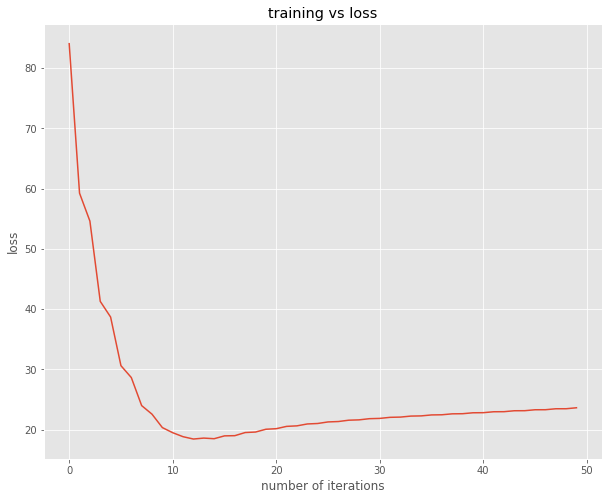

In [110]:
plt.figure(figsize= (10,8))
plt.plot(np.arange(iteration), loss)
plt.xlabel("number of iterations")
plt.ylabel("loss")
plt.title("training vs loss")